<a href="https://colab.research.google.com/github/nicolaugmachado/bootcampds-modulo3-pense2015/blob/main/Nicolau_Galv%C3%A3o_Machado_Bootcamp_Alura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando as bibliotecas

Documentação da base de dados:

https://www.kaggle.com/S%C3%ADrio-Libanes/covid19

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

In [ ]:
np.random.seed(73246)

In [ ]:
# !pip install -U pandas-profiling

In [ ]:
# import pandas_profiling

# Importação e pré-processamento da base

In [ ]:
dados = pd.read_excel("/content/drive/MyDrive/Alura/Projeto Final/dados/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx")
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

In [ ]:
# Criando uma variável só as colunas numéricas e removendo dados NaN
x_columns = dados.describe().columns
dados_limpos = dados.dropna()

In [ ]:
# Dividindo a fonte de dados em X e Y para os modelos de ML
y = dados_limpos["ICU"]
x = dados_limpos[x_columns].drop(["ICU"], axis=1)

In [ ]:
# Criando função "preenche_tabela" para:
  # Utilizar método bfill e ffill para preencher a variável ICU, de acordo com as recomendações do Sírio-Libanês
  # Agrupar linhas por PATIENT_VISIT_IDENTIFIER

def preenche_tabela(dados):
    def preenche_na(rows):
        rows.loc[rows["ICU"] != 1] = rows.loc[rows["ICU"] != 1].fillna(method='bfill').fillna(method='ffill')
        return rows
    
    features_continuas_colunas = dados.iloc[:, 13:-2].columns
    features_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[list(features_continuas_colunas) + ["ICU"]].apply(preenche_na)
    features_continuas.drop("ICU", axis=1, inplace=True)
    
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:, -2:]
    
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True, axis=1)
    dados_finais.columns = dados.columns
    
    return dados_finais

In [ ]:
dados_limpos = preenche_tabela(dados)
dados_limpos.head()
dados_limpos = dados_limpos.dropna()

In [ ]:
# Removendo pacientes com status de ICU == 1 na primeira janela de tempo, pois há possibilidade desses pacientes já estarem internados antes de período
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos = dados_limpos.dropna()
dados_limpos.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1537.000000,1537.000000,1537.000000,1537.00000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.0,1537.000000,1537.000000,1537.000000,1537.000000,1537.0,1537.000000,1537.000000,1537.000000,1537.000000,1537.0,1537.000000,1537.000000,1537.000000,1537.000000,1537.0,1537.000000,1537.000000,1537.000000,1537.000000,1537.0,1537.000000,1537.000000,1537.000000,...,1537.000000,1537.000000,1537.0,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000
mean,193.532206,0.419649,0.375407,0.10475,0.027977,0.097593,0.018868,0.121015,0.053351,0.199089,0.161353,0.826285,0.543557,0.543557,0.543557,0.543557,-1.0,-0.980314,-0.980314,-0.980314,-0.980314,-1.0,-0.951442,-0.951442,-0.951442,-0.951442,-1.0,-0.312487,-0.312487,-0.312487,-0.312487,-1.0,-0.313931,-0.313931,-0.313931,-0.313931,-1.0,-0.946193,-0.946193,-0.946193,...,-0.958619,-0.958619,-1.0,-0.055551,-0.348981,-0.263748,-0.482518,0.072595,0.747621,-0.058435,-0.354367,-0.267073,-0.478877,0.068536,0.752303,0.005346,-0.200854,-0.250232,-0.497955,0.345235,0.832616,-0.226276,-0.430903,-0.298498,-0.394097,-0.001141,0.813187,-0.782546,-0.770432,-0.784134,-0.766543,-0.803513,-0.904322,-0.815033,-0.758142,-0.839413,-0.775592,-0.804443,-0.904295,0.160052
std,111.443169,0.493662,0.484385,0.30633,0.164959,0.296860,0.136103,0.326251,0.224805,0.399445,0.367976,0.378988,0.196516,0.196516,0.196516,0.196516,0.0,0.118838,0.118838,0.118838,0.118838,0.0,0.140507,0.140507,0.140507,0.140507,0.0,0.070388,0.070388,0.070388,0.070388,0.0,0.099079,0.099079,0.099079,0.099079,0.0,0.065283,0.065283,0.065283,...,0.111910,0.111910,0.0,0.234205,0.244025,0.230956,0.171521,0.236969,0.111526,0.242174,0.247208,0.237139,0.175722,0.244070,0.109076,0.269498,0.250105,0.257458,0.222624,0.204158,0.254898,0.242930,0.259554,0.273552,0.358457,0.263971,0.124807,0.337098,0.372488,0.341442,0.431038,0.295903,0.267281,0.297967,0.385381,0.252746,0.400456,0.294567,0.267501,0.366774
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [ ]:
def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

dados_limpos.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,-0.107143,0.736842,0.333333,-0.230769,-0.132075,-0.586207,-0.107143,0.736842,0.443299,0.0000,-0.025641,-0.500000,0.318681,0.898990,-0.076923,-0.459459,-0.313433,-0.636364,-0.275362,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,-0.107143,0.736842,0.333333,-0.230769,-0.132075,-0.586207,-0.107143,0.736842,0.443299,0.0000,-0.025641,-0.500000,0.318681,0.898990,-0.076923,-0.459459,-0.313433,-0.63

In [ ]:
dados_limpos.AGE_PERCENTIL = dados_limpos.AGE_PERCENTIL.astype("category").cat.codes
dados_limpos.AGE_PERCENTIL.value_counts()

1    193
0    182
3    176
2    173
4    161
5    151
6    149
7    138
9    107
8    107
Name: AGE_PERCENTIL, dtype: int64

In [ ]:
# Removendo as variáveis PATIENT_VISIT_IDENTIFIER e WINDOW antes de começarmos a explorar os modelos de ML
dados_limpos.drop(['PATIENT_VISIT_IDENTIFIER', 'WINDOW'], axis=1, inplace=True)
dados_limpos.head()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.994912,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
1,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.994912,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
2,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.994912,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,-0.107143,0.736842,0.333333,-0.230769,-0.132075,-0.586207,-0.107143,0.736842,0.443299,0.0000,-0.025641,-0.500000,0.318681,0.898990,-0.076923,-0.459459,-0.313433,-0.636364,-0.275362,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
3,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.994912,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,-0.107143,0.736842,0.333333,-0.230769,-0.132075,-0.586207,-0.107143,0.736842,0.443299,0.0000,-0.025641,-0.500000,0.318681,0.8

In [ ]:
scaled_age_percentil = dados_limpos[['AGE_PERCENTIL']]
scaled_age_percentil.reset_index(drop=True)

,AGE_PERCENTIL
0,5
1,5
2,5
3,5
4,5
...,...
1532,4
1533,4
1534,4
1535,4


In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit(scaled_age_percentil.values)

In [ ]:
scaled_age_percentil = scaler.transform(scaled_age_percentil.values)

In [ ]:
dados_limpos['AGE_PERCENTIL'] = scaled_age_percentil
dados_limpos

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
0,1,0.111111,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.994912,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
1,1,0.111111,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.994912,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
2,1,0.111111,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.994912,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,-0.107143,0.736842,0.333333,-0.230769,-0.132075,-0.586207,-0.107143,0.736842,0.443299,0.0000,-0.025641,-0.500000,0.318681,0.898990,-0.076923,-0.459459,-0.313433,-0.636364,-0.275362,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
3,1,0.111111,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.994912,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,-0.107143,0.736842,0.333333,-0.230769,-0.132075,-0.586207,-0.107143,0.736842,0.443299,0.0000,-

In [ ]:
# Removendo as variáveis com alta correlação entre si, com um índice de coeficiente de correlação editável (threshold)

def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
                    return dataset

    print(dataset)

In [ ]:
dados_limpos = correlation(dados_limpos, 0.9)
dados_limpos

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
0,1,0.111111,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,...,-0.994912,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
1,1,0.111111,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,...,-0.994912,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
2,1,0.111111,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,...,-0.994912,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,-0.107143,0.736842,0.333333,-0.230769,-0.132075,-0.586207,-0.107143,0.736842,0.443299,0.0000,-0.025641,-0.500000,0.318681,0.898990,-0.076923,-0.459459,-0.313433,-0.636364,-0.275362,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
3,1,0.111111,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,...,-0.994912,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,-0.107143,0.736842,0.333333,-0.230769,-0.132075,-0.586207,-0.107143,0.736842,0.443299,0.

In [ ]:
dados_limpos.shape

(1537, 228)

In [ ]:
# Dividindo as variáveis X e Y em treino e teste para os modelos de ML
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

# Gráficos

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


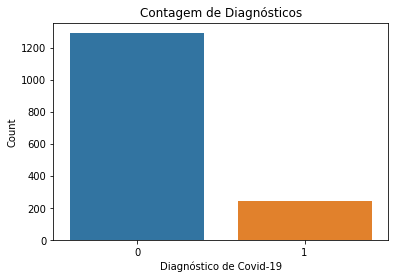

In [ ]:
sns.countplot(dados_limpos['ICU'])
plt.title('Contagem de Diagnósticos')
plt.xlabel('Diagnóstico de Covid-19')
plt.ylabel('Count')
plt.show()

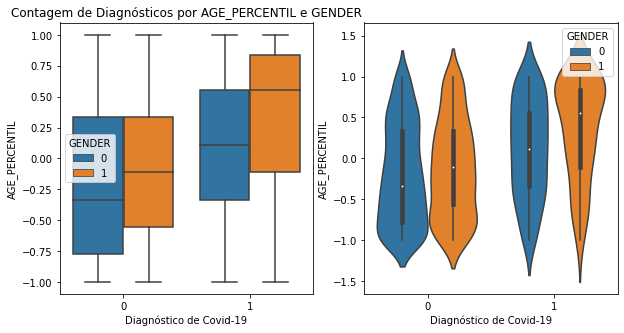

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.boxplot(x="ICU", y="AGE_PERCENTIL", hue="GENDER", data=dados_limpos)
plt.xlabel('Diagnóstico de Covid-19')
plt.title('Contagem de Diagnósticos por AGE_PERCENTIL e GENDER')
plt.subplot(1,2,2)
sns.violinplot(x="ICU", y="AGE_PERCENTIL", hue="GENDER",  data=dados_limpos)
plt.xlabel('Diagnóstico de Covid-19')
plt.show()

# Modelos

## Função Roda Modelo (com Validação Cruzada)

In [ ]:
# Função para retornar um AUC score médio de n repetições do modelo e com nº splits de cross-validation editável 

def return_mean_auc(modelo, dados, n_splits, n_repeats):

    np.random.seed(1231234)
    dados = dados.sample(frac=1).reset_index(drop=True)
    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU"], axis=1)
    
    
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
    resultados=cross_validate(modelo, x, y, cv=cv, scoring='roc_auc', return_train_score=True)
    
    auc_medio = np.mean(resultados['test_score'])*100
    print('%.2f' % auc_medio)


In [ ]:
# Função para retornar recall macro do Classification Report

def return_recall(model_pred):
    recall_01_modelo =  round(precision_recall_fscore_support(y_test, model_pred, average='macro')[1]*100, 2)
    print('%.2f' % recall_01_modelo)

In [ ]:
# Função para retornar precisão macro do Classification Report

#def return_precision(model_pred):
#    precision_macro_modelo =  round(precision_recall_fscore_support(y_test, model_pred, average='macro')[0]*100, 2)
#    print('%.2f' % precision_macro_modelo)

### Regressão Logística

In [ ]:
# Criando um modelo de Regressão Logística
logreg = LogisticRegression(max_iter=1000)

In [ ]:
# Treinando o modelo e realizando a previsão
logreg.fit(x_train,y_train)
predict_logreg = logreg.predict(x_test)

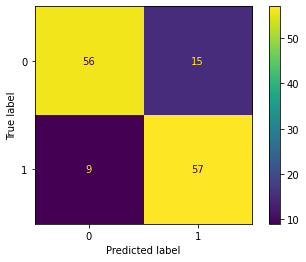

In [ ]:
# Matriz de confusão do modelo
plot_confusion_matrix(logreg, x_test, y_test)

In [ ]:
print(classification_report(y_test, predict_logreg))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82        71
           1       0.79      0.86      0.83        66

    accuracy                           0.82       137
   macro avg       0.83      0.83      0.82       137
weighted avg       0.83      0.82      0.82       137



In [ ]:
# Acurácia do Modelo
round(accuracy_score(y_test, predict_logreg)*100, 2)

82.48

In [ ]:
# Recall (macro) do Modelo
return_recall(predict_logreg)

82.62


In [ ]:
# AUC médio do Modelo
return_mean_auc(logreg, dados_limpos, 5, 10)

96.06


### Classificador Naive Bayes

In [ ]:
# Criando um modelo gaussiano Naive Bayes
model_nb = GaussianNB()

In [ ]:
# Treinando o modelo e realizando a previsão
model_nb.fit(x_train,y_train)
predict_nb = model_nb.predict(x_test)

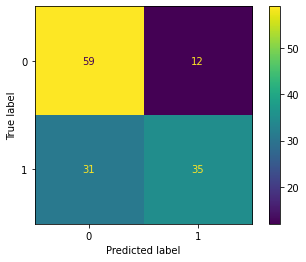

In [ ]:
# Matriz de confusão do modelo
plot_confusion_matrix(model_nb, x_test, y_test)

In [ ]:
print(classification_report(y_test, predict_nb))

              precision    recall  f1-score   support

           0       0.66      0.83      0.73        71
           1       0.74      0.53      0.62        66

    accuracy                           0.69       137
   macro avg       0.70      0.68      0.68       137
weighted avg       0.70      0.69      0.68       137



In [ ]:
# Acurácia do Modelo
round(accuracy_score(y_test, predict_nb)*100, 2)

68.61

In [ ]:
# Recall (macro) do Modelo
return_recall(predict_nb)

68.06


In [ ]:
# AUC médio do Modelo
return_mean_auc(model_nb, dados_limpos, 5, 10)

89.81


### Decision Tree

In [ ]:
# Criando um modelo de árvore de decisão
model_tree = DecisionTreeClassifier()

In [ ]:
# Otimização dos principais hiper-parâmetros
parameters = {'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10, 50], 
              'min_samples_split': [2, 3, 50, 100],
              'min_samples_leaf': [1, 5, 8, 10]
             }

grid_obj = GridSearchCV(model_tree, parameters)
grid_obj = grid_obj.fit(x_train, y_train)

# Configurando o modelo com a melhor combinação de hiper-parâmetros
model_tree = grid_obj.best_estimator_

In [ ]:
# Treinando o modelo e realizando a previsão
model_tree.fit(x_train,y_train)
predict_tree = model_tree.predict(x_test)

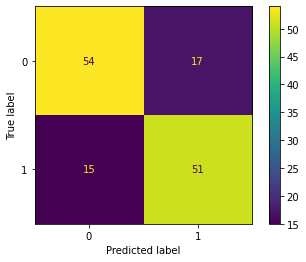

In [ ]:
# Matriz de confusão do modelo
plot_confusion_matrix(model_tree, x_test, y_test)

In [ ]:
print(classification_report(y_test, predict_tree))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77        71
           1       0.75      0.77      0.76        66

    accuracy                           0.77       137
   macro avg       0.77      0.77      0.77       137
weighted avg       0.77      0.77      0.77       137



In [ ]:
# Acurácia do Modelo
round(accuracy_score(y_test, predict_tree)*100, 2)

76.64

In [ ]:
# Recall (macro) do Modelo
return_recall(predict_tree)

76.66


In [ ]:
# AUC médio do Modelo
return_mean_auc(model_tree, dados_limpos, 5, 10)

88.43


### Random Forest

In [ ]:
# Criando um modelo Random Forest
model_forest = RandomForestClassifier()

In [ ]:
# Treinando o modelo e realizando a previsão
model_forest.fit(x_train,y_train)
predict_forest = model_forest.predict(x_test)

In [ ]:
# Acurácia do Modelo (antes da otimização de hiper-parâmetros)
round(accuracy_score(y_test, predict_forest)*100, 2)

83.94

In [ ]:
# Otimização dos principais hiper-parâmetros
parameters = {'n_estimators': [4, 6, 9, 10, 15], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8]
             }

grid_obj = GridSearchCV(model_forest, parameters)
grid_obj = grid_obj.fit(x_train, y_train)

# Configurando o modelo com a melhor combinação de hiper-parâmetros
model_forest = grid_obj.best_estimator_

In [ ]:
# Acurácia do Modelo (após da otimização de hiper-parâmetros)
round(accuracy_score(y_test, predict_forest)*100, 2)

86.13

In [ ]:
# Treinando o modelo e realizando a previsão
model_forest.fit(x_train,y_train)
predict_forest = model_forest.predict(x_test)

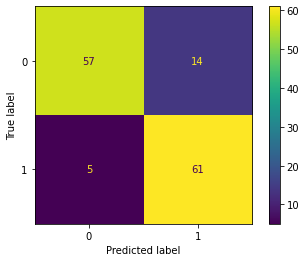

In [ ]:
# Matriz de confusão do modelo
plot_confusion_matrix(model_forest, x_test, y_test)

In [ ]:
print(classification_report(y_test, predict_forest))

              precision    recall  f1-score   support

           0       0.92      0.80      0.86        71
           1       0.81      0.92      0.87        66

    accuracy                           0.86       137
   macro avg       0.87      0.86      0.86       137
weighted avg       0.87      0.86      0.86       137



In [ ]:
# Recall (macro) do Modelo
return_recall(predict_forest)

86.35


In [ ]:
# AUC médio do Modelo
return_mean_auc(model_forest, dados_limpos, 5, 10)

96.49


### KNN

In [ ]:
# Criando um modelo k- nearest neighbors
knn = KNeighborsClassifier()

In [ ]:
# Otimização dos principais hiper-parâmetros
parameters = {'n_neighbors': [3, 4, 5, 10], 
              'weights': ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size' : [10, 20, 30, 50]
             }

grid_obj = GridSearchCV(knn, parameters)
grid_obj = grid_obj.fit(x_train, y_train)

# Configurando o modelo com a melhor combinação de hiper-parâmetros
knn = grid_obj.best_estimator_

In [ ]:
# Treinando o modelo e realizando a previsão
knn.fit(x_train,y_train)
knn_pred = knn.predict(x_test)

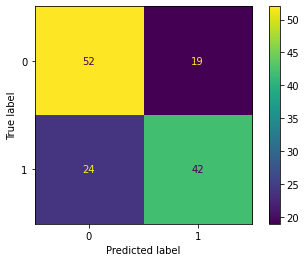

In [ ]:
# Matriz de confusão do modelo
plot_confusion_matrix(knn, x_test, y_test)

In [ ]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.68      0.73      0.71        71
           1       0.69      0.64      0.66        66

    accuracy                           0.69       137
   macro avg       0.69      0.68      0.68       137
weighted avg       0.69      0.69      0.69       137



In [ ]:
# Acurácia do Modelo
round(accuracy_score(y_test, knn_pred)*100, 2)

68.61

In [ ]:
# Recall (macro) do Modelo
return_recall(knn_pred)

68.44


In [ ]:
# AUC médio do Modelo
return_mean_auc(knn, dados_limpos, 5, 10)

90.28


# Melhor Modelo

Para a avaliação dos modelos foram escolhidas 3 métricas principais:

**Acurácia**, pois é uma boa indicação geral de como o modelo performou.

**Recall**, pois  pode ser usada em uma situação em que os Falsos Negativos são considerados mais prejudiciais que os Falsos Positivos. Por exemplo, o modelo deve de qualquer maneira encontrar todos os pacientes doentes, mesmo que classifique alguns saudáveis como doentes (situação de Falso Positivo) no processo. Ou seja, o modelo deve ter alto recall, pois classificar pacientes doentes como saudáveis é grave para o nosso modelo.

**AUC**, pois representa o grau ou medida de separabilidade. Por exemplo, quanto maior a AUC, melhor o modelo está em distinguir entre positivo e negativo, pacientes com doença e pacientes sem doença


Acurácia (macro) dos Modelos

In [ ]:
round(accuracy_score(y_test, predict_logreg)*100, 2)

82.48

In [ ]:
round(accuracy_score(y_test, predict_nb)*100, 2)

68.61

In [ ]:
round(accuracy_score(y_test, predict_tree)*100, 2)

76.64

In [ ]:
round(accuracy_score(y_test, predict_forest)*100, 2)

86.13

In [ ]:
round(accuracy_score(y_test, knn_pred)*100, 2)

68.61

Recall (macro) dos Modelos

In [ ]:
return_recall(predict_logreg)

82.62


In [ ]:
return_recall(predict_nb)

68.06


In [ ]:
return_recall(predict_tree)

76.66


In [ ]:
return_recall(predict_forest)

86.35


In [ ]:
return_recall(knn_pred)

68.44


AUC médio do Modelo

In [ ]:
return_mean_auc(logreg, dados_limpos, 5, 10)

96.06


In [ ]:
return_mean_auc(model_nb, dados_limpos, 5, 10)

89.81


In [ ]:
return_mean_auc(model_tree, dados_limpos, 5, 10)

88.43


In [ ]:
return_mean_auc(model_forest, dados_limpos, 5, 10)

96.49


In [ ]:
return_mean_auc(knn, dados_limpos, 5, 10)

90.28


## **Conclusão**

O modelo otimizado de Random Forest teve o melhor desempenho nas principais de avaliação. Porém, o modelo de Regressão Logística teve o melhor AUC score. É importante ressaltar que a base do Sírio-Libanês é relativamente pequena. Por isso, seria recomendável treinar esses dois modelos com uma amostra maior